In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

In [115]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
#df = df[["datetime","power_production_wind_avg","timestamp","power_production_solar_avg"]]
    

day = 24*60*60
year = (365.2425)*day

df['sin_hour_of_day'] = np.sin(df["timestamp"] * (2 * np.pi / day))
df['cos_hour_of_day'] = np.cos(df["timestamp"] * (2 * np.pi / day))
df['sin_day_of_year'] = np.sin(df["timestamp"] * (2 * np.pi / year))
df['cos_day_of_year'] = np.cos(df["timestamp"] * (2 * np.pi / year))

# # seperate datetime into hour of day, day of year, and month of year
# df["datetime"] = pd.to_datetime(df["datetime"])
# df["hour_of_day"] = df["datetime"].dt.hour
# df["day_of_year"] = df["datetime"].dt.day_of_year
# df["month_of_year"] = df["datetime"].dt.month

# # rescale data (min-max normalization)
# df_norm = df.drop("datetime", axis=1)
# df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

# # add sin time columns (range: 0-1)
# df_sin = df_norm.drop("power_production_wind_avg", axis=1)
# df_sin = df_sin.apply(lambda x: np.sin(2*np.pi*x))
# df_sin = df_sin.add_prefix("sin_")

# # add cos time columns (range: 0-1)
# df_cos = df_norm.drop("power_production_wind_avg", axis=1)
# df_cos = df_cos.apply(lambda x: np.cos(2*np.pi*x))
# df_cos = df_cos.add_prefix("cos_")

# merge columns
#y = pd.concat([df_norm, df_sin,df_cos], axis=1)
#y=df.drop(["datetime","timestamp"],axis=1)

y=df.drop(["datetime","timestamp","created_at","updated_at","zone_name","production_sources"],axis=1)
y = (y-y.min())/(y.max()-y.min())
y.head()

,carbon_intensity_avg,carbon_intensity_direct_avg,carbon_intensity_production_avg,carbon_intensity_discharge_avg,carbon_intensity_import_avg,total_production_avg,total_storage_avg,total_discharge_avg,total_import_avg,total_export_avg,...,latest_forecasted_power_net_import_NO-NO2_avg,latest_forecasted_power_net_import_PL_avg,latest_forecasted_power_net_import_SE_avg,latest_forecasted_power_net_import_SE-SE4_avg,latest_forecasted_production_solar_avg,latest_forecasted_production_wind_avg,sin_hour_of_day,cos_hour_of_day,sin_day_of_year,cos_day_of_year
0,0.718282,0.701216,0.712148,NaN,0.477059,0.168979,0.000000,0.003301,0.454622,0.416573,...,0.499821,0.461538,1.0,1.0,0.0,0.091781,0.500000,1.000000,0.505440,0.999970
1,0.729032,0.711724,0.726887,NaN,0.451743,0.162390,0.039003,0.000000,0.439337,0.455586,...,0.499821,0.461846,1.0,1.0,0.0,0.081291,0.629410,0.982963,0.505799,0.999966
2,0.746997,0.730134,0.744847,NaN,0.464592,0.158075,0.484624,0.000000,0.451383,0.360486,...,0.499821,0.461538,1.0,1.0,0.0,0.071769,0.750000,0.933013,0.506157,0.999962
3,0.747887,0.731118,0.751650,NaN,0.453842,0.148506,0.633661,0.000000,0.474848,0.286454,...,0.499821,0.461538,1.0,1.0,0.0,0.065730,0.853553,0.853553,0.506515,0.999958
4,0.767731,0.750326,0.764711,NaN,0.475045,0.151631,0.486453,0.000000,0.444501,0.361922,...,0.499821,0.461538,1.0,1.0,0.0,0.060377,0.933013,0.750000,0.506874,0.999953


# Correlation matrix
Features that are highly correlated with other features show redundant information.
Are features that correlate strongly with the power_production_wind_avg most important?

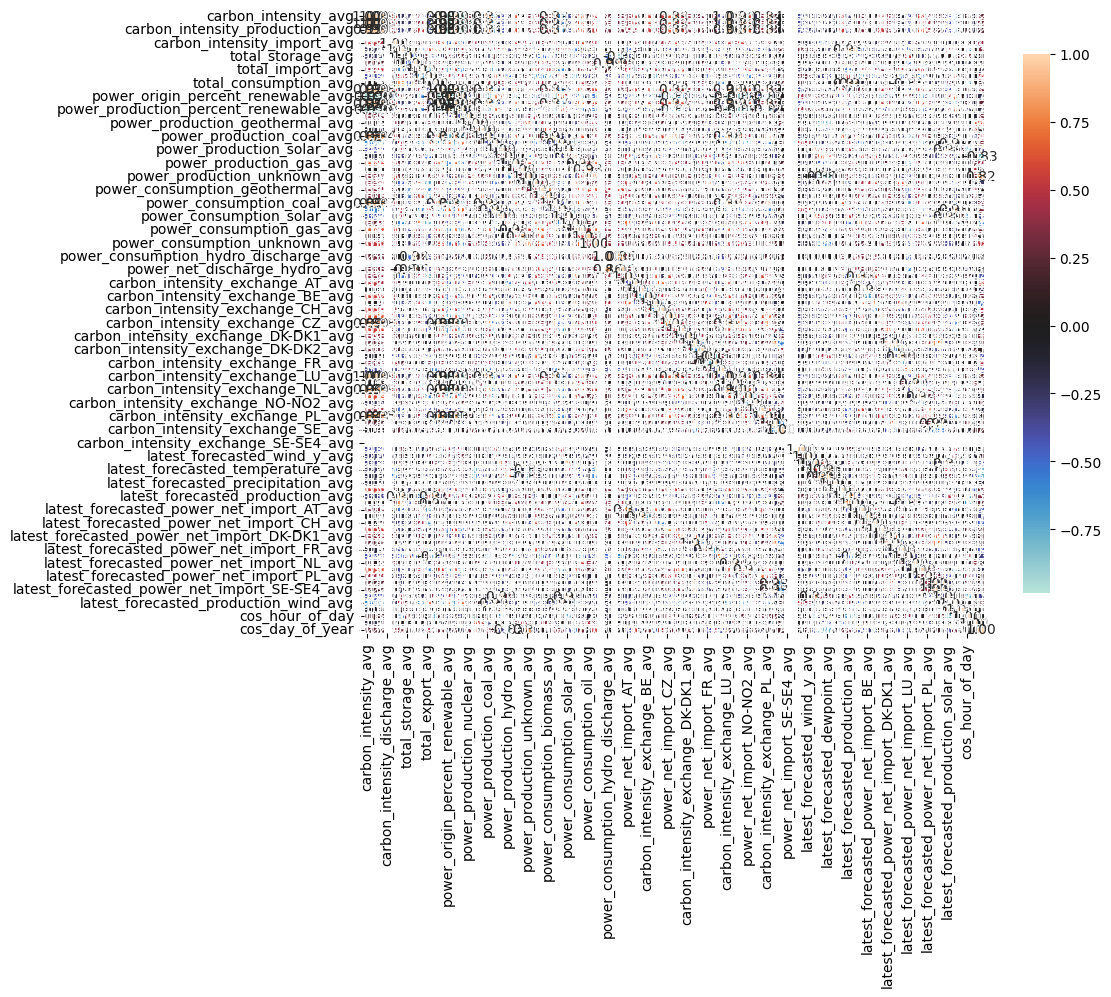

In [116]:
def correlation_heatmap(y):
    correlations = y.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(y)

# Fast Fourier Transform

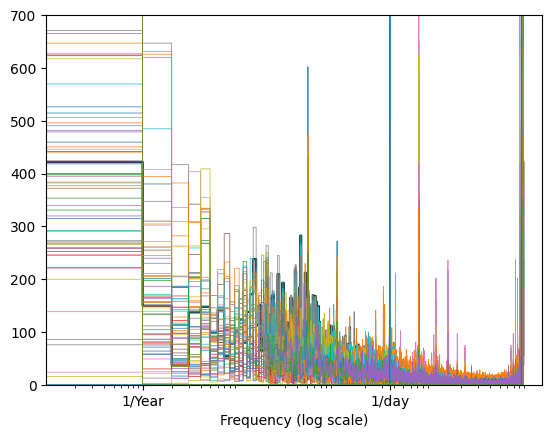

In [122]:
f_per_dataset = np.arange(0, len(y))#/2+1)
n_samples_h = len(df["power_production_wind_avg"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset

# apply and plot fast fourier transform (FFT)
for column in y:
    #fft = tf.signal.rfft(y[column])
    fft = np.fft.fft(y[column])
    # norm amplitude by maximum
    maxFFT = np.max(np.abs(fft))
    maxFFT = 1
    # plot
    if (column=="power_production_wind_avg"):
         plt.step(f_per_year, np.abs(fft)/maxFFT,label=column,lw=1.5,c="black",zorder=1)
    plt.step(f_per_year, np.abs(fft)/maxFFT,label=column,lw = 0.5)
    

    
plt.xscale('log')
plt.ylim(0, 700)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left)
